In [2]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np
import matplotlib.pyplot as plt

tf.set_random_seed(1)
np.random.seed(1)

BATCH_SIZE = 50
LR = 0.001 # learning rate

mnist = input_data.read_data_sets('MNIST_data/', one_hot=True) # they have been normalized to range(0, 1)
test_x = mnist.test.images[:2000]
test_y = mnist.test.labels[:2000]

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


(55000, 784)
(55000, 10)


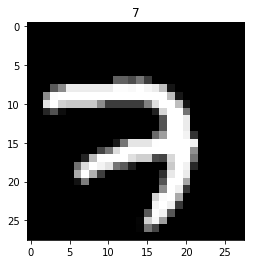

In [3]:
# plot one example 
print(mnist.train.images.shape) # (55000, 784)
print(mnist.train.labels.shape) # (55000, 10)
plt.imshow(mnist.train.images[0].reshape((28, 28)), cmap='gray')
plt.title('%i'%np.argmax(mnist.train.labels[0]))
plt.show()

Step: 0 |train loss: 2.2884 |test accuracy: 0.18


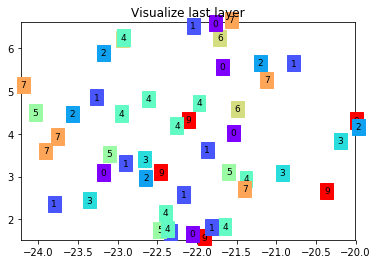

Step: 50 |train loss: 0.3878 |test accuracy: 0.54


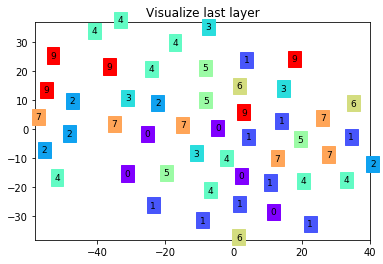

Step: 100 |train loss: 0.2979 |test accuracy: 0.65


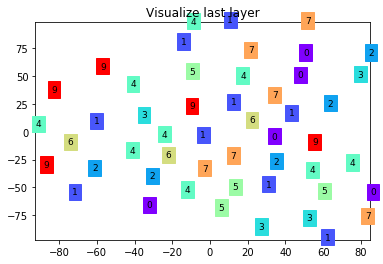

Step: 150 |train loss: 0.3320 |test accuracy: 0.71


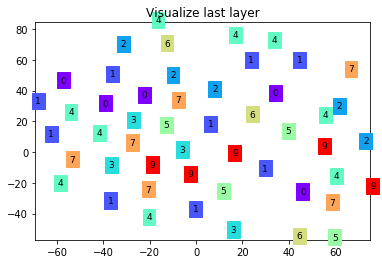

Step: 200 |train loss: 0.3235 |test accuracy: 0.76


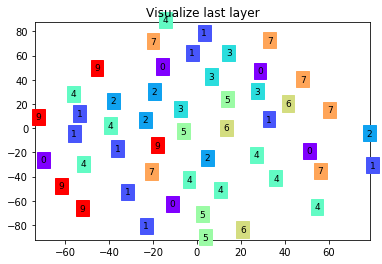

Step: 250 |train loss: 0.4508 |test accuracy: 0.78


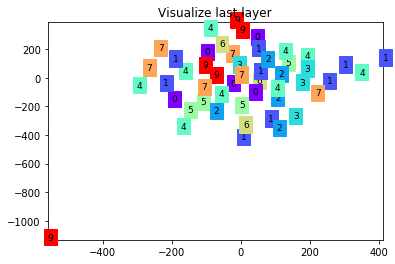

Step: 300 |train loss: 0.1075 |test accuracy: 0.81


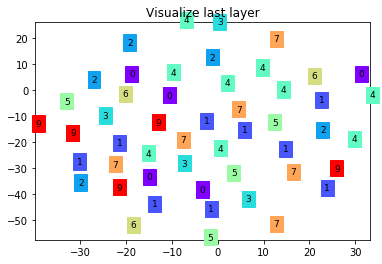

Step: 350 |train loss: 0.0613 |test accuracy: 0.84


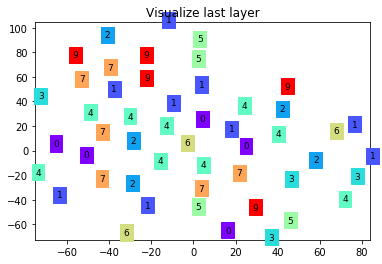

Step: 400 |train loss: 0.3933 |test accuracy: 0.84


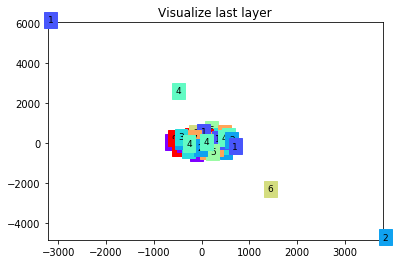

Step: 450 |train loss: 0.0760 |test accuracy: 0.85


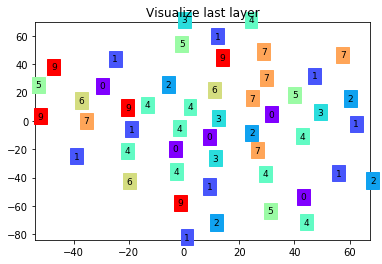

Step: 500 |train loss: 0.1432 |test accuracy: 0.86


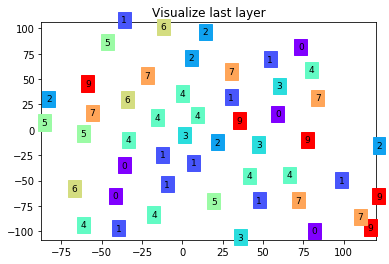

Step: 550 |train loss: 0.0430 |test accuracy: 0.87


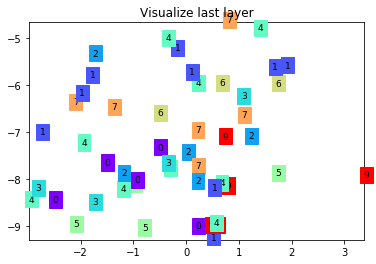

[7 2 1 0 4 1 4 9 5 9] prediction number
[7 2 1 0 4 1 4 9 5 9] real number


In [14]:
# visualization 
from matplotlib import cm
try:
    from sklearn.manifold import TSNE
    HAS_SK=True
except: 
    HAS_SK =False
    print('n\Please install sklearn for layer visualization\n')
def plot_with_labels(lowDWeights, labels):
    plt.cla()
    X, Y = lowDWeights[:, 0], lowDWeights[:, 1]
    for x, y, s in zip(X, Y, labels):
        c = cm.rainbow(int(255*s/9))
        plt.text(x, y, s, backgroundcolor=c, fontsize=9)
    plt.xlim(X.min(), X.max())
    plt.ylim(Y.min(), Y.max())
    plt.title('Visualize last layer')
    plt.show()
    plt.pause(0.1)

with tf.Graph().as_default(), tf.Session() as sess:
    tf_x = tf.placeholder(tf.float32, [None, 28*28])/255 # input x
    image = tf.reshape(tf_x, [-1, 28, 28, 1]) # (batch, height, width, channel)
    tf_y = tf.placeholder(tf.int32, [None, 10]) # input y(labels)
    
    # CNN
    conv1 = tf.layers.conv2d(
        inputs = image,
        filters = 16,
        kernel_size = 5,
        strides = 1,
        padding = 'same',
        activation = tf.nn.relu
    ) # (image(28, 28, 1)) --> (feature maps(28, 28, 16))
    pool1  = tf.layers.max_pooling2d(
        conv1,
        pool_size=2,
        strides = 2,
    )# -->(feature maps(14, 14, 16))
    conv2 = tf.layers.conv2d(pool1, 32, 5, 1, 'same', activation=tf.nn.relu) # --> (14, 14, 32)
    pool2 = tf.layers.max_pooling2d(conv2, 2, 2) # --> (7, 7, 32)
    flat = tf.reshape(pool2, [-1, 7*7*32]) # -->(7*7*32,)
    output = tf.layers.dense(flat, 10) # output layer
    
    loss = tf.losses.softmax_cross_entropy(onehot_labels=tf_y, logits=output)
    train_op = tf.train.AdamOptimizer(LR).minimize(loss)
    
    accuracy = tf.metrics.accuracy( #return (acc, updata_oop), and create 2 loacl variables)
        labels=tf.argmax(tf_y, axis=1),
        predictions = tf.argmax(output, axis=1),
    )[1]
    
    init_op = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer()) # the loacl var is for accuracy_op
    sess.run(init_op) # initizlize var in graph
    
    plt.ion()
    for step in range(600):
        b_x, b_y = mnist.train.next_batch(BATCH_SIZE)
        _, loss_ = sess.run([train_op, loss], {tf_x:b_x, tf_y:b_y})
        if step%50==0:
            acc_, flat_representation = sess.run([accuracy, flat], {tf_x:b_x, tf_y:b_y})
            print('Step:',step, '|train loss: %.4f'%loss_, '|test accuracy: %.2f'%acc_)
            
            if HAS_SK:
                # visulization of trained flatten layer (T-SNE)
                tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
                plot_only = 500
                low_dim_embs = tsne.fit_transform(flat_representation[:plot_only, :])
                labels = np.argmax(test_y, axis=1)[:plot_only]
                plot_with_labels(low_dim_embs, labels)
    plt.ioff()
    
    # print 10 preditions from test data
    test_output = sess.run(output, {tf_x:test_x[:10]})
    pred_y = np.argmax(test_output, 1)
    print(pred_y, 'prediction number')
    print(np.argmax(test_y[:10], 1), 'real number')

这一节有很多不懂的东西，需要之后好好回顾。